# LwF

$$
\mathcal{L} = 
$$

In [1]:
%load_ext autoreload
%autoreload 2

# Libraries

In [2]:
import pickle
from tqdm import tqdm

In [3]:
from avalanche.benchmarks.classic import PermutedMNIST
from avalanche.models import SimpleMLP
from avalanche.training import LwF
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger
from avalanche.evaluation.metrics import (
    accuracy_metrics,
    bwt_metrics,
    confusion_matrix_metrics,
    forgetting_metrics,
    timing_metrics,
    cpu_usage_metrics,
    gpu_usage_metrics,
    disk_usage_metrics,
    ram_usage_metrics,
    loss_metrics,
    class_accuracy_metrics,
    accuracy_matrix_metrics
)

from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch import cuda

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Custom Libraries

In [4]:
import sys

sys.path.append("../base_code/")

from base_code.constants import DATASETS_PATH, SAVED_METRICS_PATH
from base_code.plugins import WeightStoragePlugin

# Constants

In [5]:
TORCH_DEVICE = "cuda" if cuda.is_available() else "cpu"
N_EXPERIENCES = 10
EXPERIMENT_SEED = 1234
METRICS_SUBFOLDER = "standard"
METRICS_FILENAME = f"{METRICS_SUBFOLDER}/lwf.pkl"

# Dataset and definitions

## Dataset loading

We load state-of-the-art dataset Modified NIST

In [6]:
scenario = PermutedMNIST(N_EXPERIENCES, seed=EXPERIMENT_SEED, dataset_root=DATASETS_PATH)

## Scenario creation with train test streaming

In this point, we define our scenario considering a training where in every experience of it, a new class is presented. This is, first we train with a class $a$, the following experience we train with class $b$ ($a \neq b$)

In [7]:
train_stream = scenario.train_stream
test_stream = scenario.test_stream

# Model Selection

In [8]:
from math import floor
from itertools import product
from typing import List

# Constants
MODEL_SELECTION_MAX_EXPERIENCES = floor(N_EXPERIENCES * 0.2)

strategy_hyperparameters_grid = {
    "alpha": [0.5, 0.7, 0.9],
    "temperature": [2, 5, 10, 20],
}

# Create the models
models = [
    SimpleMLP(num_classes=scenario.n_classes, hidden_size=100, input_size=28 * 28).to(TORCH_DEVICE)
    for _ in product(*strategy_hyperparameters_grid.values())
]
hyperparameters_product = list(product(*strategy_hyperparameters_grid.values()))

strategies: List[LwF] = []
for model, hyperparameters in zip(models, hyperparameters_product):
    strategy = LwF(
        model,
        SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005),
        CrossEntropyLoss(),
        train_mb_size=100,
        train_epochs=1,
        eval_mb_size=100,
        device=TORCH_DEVICE,
        evaluator=EvaluationPlugin(
            accuracy_metrics(
                stream=True
            ),
        ),
        **dict(zip(strategy_hyperparameters_grid.keys(), hyperparameters)),
    )
    strategies.append(strategy)

# train each model on the first 20% of the experiences
for i, strategy in enumerate(strategies):
    print(f"Training model {i + 1}/{len(strategies)}")
    for experience in train_stream[:MODEL_SELECTION_MAX_EXPERIENCES]:
        strategy.train(experience)
    strategy.eval(train_stream[:MODEL_SELECTION_MAX_EXPERIENCES])


/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Training model 1/12
Training model 2/12
Training model 3/12
Training model 4/12
Training model 5/12
Training model 6/12
Training model 7/12
Training model 8/12
Training model 9/12
Training model 10/12
Training model 11/12
Training model 12/12


In [9]:
# Get the model with the best averaged accuracy
best_hyperparameters_idx = -1
best_avg_accuracy = 0

for i, strategy in enumerate(strategies):
    avg_accuracy = strategy.evaluator.get_last_metrics()["Top1_Acc_Stream/eval_phase/train_stream/Task000"]
    if avg_accuracy > best_avg_accuracy:
        best_avg_accuracy = avg_accuracy
        best_hyperparameters_idx = i

best_hyperparameters = dict(zip(strategy_hyperparameters_grid.keys(), hyperparameters_product[best_hyperparameters_idx]))

In [10]:
best_hyperparameters

{'alpha': 0.7, 'temperature': 20}

## Evaluation metrics definition

In [11]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    loss_metrics(minibatch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    cpu_usage_metrics(minibatch=True, experience=True, stream=True),
    gpu_usage_metrics(experience=True, stream=True, gpu_id=TORCH_DEVICE),
    disk_usage_metrics(experience=True, stream=True),
    ram_usage_metrics(experience=True, stream=True),
    class_accuracy_metrics(experience=True, stream=True),
    accuracy_matrix_metrics(),
    forgetting_metrics(experience=True, stream=True),
    bwt_metrics(experience=True, stream=True),
    confusion_matrix_metrics(stream=True, num_classes=scenario.n_classes),
    
    loggers=[InteractiveLogger()]
)

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")
/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")


## Plugin defitinitions

In [12]:
model_plugins = [WeightStoragePlugin()]

## Model, Optimizer, Loss function and Strategy definition

* `model`: Multi Layer Perceptron
* `Optimizer`: Adam
* `Loss function`: Cross Entropy
* `Strategy`: Elastic Weight Consolidation

In [13]:
model = SimpleMLP(num_classes=scenario.n_classes, input_size=28 * 28, hidden_layers=2, hidden_size=100).to(TORCH_DEVICE)
optimizer = SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
criterion = CrossEntropyLoss().to(TORCH_DEVICE)
strategy = LwF(
    model,
    optimizer,
    criterion,
    train_epochs=5,
    train_mb_size=128,
    plugins=model_plugins,
    evaluator=eval_plugin,
    eval_mb_size=128,
    device=TORCH_DEVICE,
    **best_hyperparameters
)

# Training and evaluation

Revisar porque el entrenamiento se está comportando de forma rara

  0%|          | 0/10 [00:00<?, ?it/s]

-- >> Start of training phase << --
100%|██████████| 469/469 [00:03<00:00, 127.77it/s]
Epoch 0 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 114.5000
	Loss_MB/train_phase/train_stream/Task000 = 0.9188
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 3.6705
100%|██████████| 469/469 [00:03<00:00, 128.24it/s]
Epoch 1 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 122.6000
	Loss_MB/train_phase/train_stream/Task000 = 0.8871
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 3.6569
100%|██████████| 469/469 [00:03<00:00, 128.30it/s]
Epoch 2 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 112.9000
	Loss_MB/train_phase/train_stream/Task000 = 0.6925
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 3.6555
100%|██████████| 469/469 [00:03<00:00, 126.09it/s]
Epoch 3 ended.
	CPUUsage_MB/train_phase/train_

 10%|█         | 1/10 [00:26<03:59, 26.65s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 106.2607
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x28328bbb0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 3612.9199
	EvalStream/Acc_Matrix = 
tensor([[0.9102, 0.1406, 0.1349, 0.1428, 0.1141, 0.1181, 0.1472, 0.1003, 0.1213,
         0.1495],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 20%|██        | 2/10 [00:55<03:44, 28.12s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 106.3686
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x2833db550>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 3612.9199
	EvalStream/Acc_Matrix = 
tensor([[0.9102, 0.1406, 0.1349, 0.1428, 0.1141, 0.1181, 0.1472, 0.1003, 0.1213,
         0.1495],
        [0.8924, 0.9264, 0.1411, 0.1172, 0.1207, 0.0944, 0.1176, 0.1011, 0.1306,
         0.1680],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 30%|███       | 3/10 [01:23<03:15, 27.97s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 106.4345
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x283ddda90>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 3612.9199
	EvalStream/Acc_Matrix = 
tensor([[0.9102, 0.1406, 0.1349, 0.1428, 0.1141, 0.1181, 0.1472, 0.1003, 0.1213,
         0.1495],
        [0.8924, 0.9264, 0.1411, 0.1172, 0.1207, 0.0944, 0.1176, 0.1011, 0.1306,
         0.1680],
        [0.8745, 0.9001, 0.9330, 0.0969, 0.0975, 0.1207, 0.0823, 0.1092, 0.1126,
         0.1256],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 40%|████      | 4/10 [01:51<02:47, 27.88s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 106.3665
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x284b33d00>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 3612.9199
	EvalStream/Acc_Matrix = 
tensor([[0.9102, 0.1406, 0.1349, 0.1428, 0.1141, 0.1181, 0.1472, 0.1003, 0.1213,
         0.1495],
        [0.8924, 0.9264, 0.1411, 0.1172, 0.1207, 0.0944, 0.1176, 0.1011, 0.1306,
         0.1680],
        [0.8745, 0.9001, 0.9330, 0.0969, 0.0975, 0.1207, 0.0823, 0.1092, 0.1126,
         0.1256],
        [0.8332, 0.8681, 0.9155, 0.9355, 0.0653, 0.0803, 0.0932, 0.0958, 0.1114,
         0.1126],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 50%|█████     | 5/10 [02:27<02:33, 30.75s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.8925
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x284f7cc10>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 3612.9199
	EvalStream/Acc_Matrix = 
tensor([[0.9102, 0.1406, 0.1349, 0.1428, 0.1141, 0.1181, 0.1472, 0.1003, 0.1213,
         0.1495],
        [0.8924, 0.9264, 0.1411, 0.1172, 0.1207, 0.0944, 0.1176, 0.1011, 0.1306,
         0.1680],
        [0.8745, 0.9001, 0.9330, 0.0969, 0.0975, 0.1207, 0.0823, 0.1092, 0.1126,
         0.1256],
        [0.8332, 0.8681, 0.9155, 0.9355, 0.0653, 0.0803, 0.0932, 0.0958, 0.1114,
         0.1126],
        [0.8135, 0.8456, 0.8988, 0.9116, 0.9374, 0.0897, 0.0796, 0.0912, 0.1332,
         0.1413],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 60%|██████    | 6/10 [02:57<02:02, 30.52s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.8136
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x2851c9850>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 3612.9199
	EvalStream/Acc_Matrix = 
tensor([[0.9102, 0.1406, 0.1349, 0.1428, 0.1141, 0.1181, 0.1472, 0.1003, 0.1213,
         0.1495],
        [0.8924, 0.9264, 0.1411, 0.1172, 0.1207, 0.0944, 0.1176, 0.1011, 0.1306,
         0.1680],
        [0.8745, 0.9001, 0.9330, 0.0969, 0.0975, 0.1207, 0.0823, 0.1092, 0.1126,
         0.1256],
        [0.8332, 0.8681, 0.9155, 0.9355, 0.0653, 0.0803, 0.0932, 0.0958, 0.1114,
         0.1126],
        [0.8135, 0.8456, 0.8988, 0.9116, 0.9374, 0.0897, 0.0796, 0.0912, 0.1332,
         0.1413],
        [0.7526, 0.7976, 0.8823, 0.9005, 0.9234, 0.9389, 0.0978, 0.1190, 0.1177,
         0.1030],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 70%|███████   | 7/10 [03:28<01:31, 30.64s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.6584
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x285625f40>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 3612.9199
	EvalStream/Acc_Matrix = 
tensor([[0.9102, 0.1406, 0.1349, 0.1428, 0.1141, 0.1181, 0.1472, 0.1003, 0.1213,
         0.1495],
        [0.8924, 0.9264, 0.1411, 0.1172, 0.1207, 0.0944, 0.1176, 0.1011, 0.1306,
         0.1680],
        [0.8745, 0.9001, 0.9330, 0.0969, 0.0975, 0.1207, 0.0823, 0.1092, 0.1126,
         0.1256],
        [0.8332, 0.8681, 0.9155, 0.9355, 0.0653, 0.0803, 0.0932, 0.0958, 0.1114,
         0.1126],
        [0.8135, 0.8456, 0.8988, 0.9116, 0.9374, 0.0897, 0.0796, 0.0912, 0.1332,
         0.1413],
        [0.7526, 0.7976, 0.8823, 0.9005, 0.9234, 0.9389, 0.0978, 0.1190, 0.1177,
         0.1030],
        [0.7113, 0.7522, 0.8278, 0.8716, 0.8897, 0.9209, 0.9399, 0.0954, 0.1232,
         0.1262],
    

 80%|████████  | 8/10 [03:57<01:00, 30.32s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.7526
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x286c1e1f0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 3612.9199
	EvalStream/Acc_Matrix = 
tensor([[0.9102, 0.1406, 0.1349, 0.1428, 0.1141, 0.1181, 0.1472, 0.1003, 0.1213,
         0.1495],
        [0.8924, 0.9264, 0.1411, 0.1172, 0.1207, 0.0944, 0.1176, 0.1011, 0.1306,
         0.1680],
        [0.8745, 0.9001, 0.9330, 0.0969, 0.0975, 0.1207, 0.0823, 0.1092, 0.1126,
         0.1256],
        [0.8332, 0.8681, 0.9155, 0.9355, 0.0653, 0.0803, 0.0932, 0.0958, 0.1114,
         0.1126],
        [0.8135, 0.8456, 0.8988, 0.9116, 0.9374, 0.0897, 0.0796, 0.0912, 0.1332,
         0.1413],
        [0.7526, 0.7976, 0.8823, 0.9005, 0.9234, 0.9389, 0.0978, 0.1190, 0.1177,
         0.1030],
        [0.7113, 0.7522, 0.8278, 0.8716, 0.8897, 0.9209, 0.9399, 0.0954, 0.1232,
         0.1262],
    

 90%|█████████ | 9/10 [04:28<00:30, 30.38s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.6717
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x286faad00>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 3612.9199
	EvalStream/Acc_Matrix = 
tensor([[0.9102, 0.1406, 0.1349, 0.1428, 0.1141, 0.1181, 0.1472, 0.1003, 0.1213,
         0.1495],
        [0.8924, 0.9264, 0.1411, 0.1172, 0.1207, 0.0944, 0.1176, 0.1011, 0.1306,
         0.1680],
        [0.8745, 0.9001, 0.9330, 0.0969, 0.0975, 0.1207, 0.0823, 0.1092, 0.1126,
         0.1256],
        [0.8332, 0.8681, 0.9155, 0.9355, 0.0653, 0.0803, 0.0932, 0.0958, 0.1114,
         0.1126],
        [0.8135, 0.8456, 0.8988, 0.9116, 0.9374, 0.0897, 0.0796, 0.0912, 0.1332,
         0.1413],
        [0.7526, 0.7976, 0.8823, 0.9005, 0.9234, 0.9389, 0.0978, 0.1190, 0.1177,
         0.1030],
        [0.7113, 0.7522, 0.8278, 0.8716, 0.8897, 0.9209, 0.9399, 0.0954, 0.1232,
         0.1262],
    

100%|██████████| 10/10 [06:57<00:00, 41.71s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 98.5792
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x2871dd550>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 3612.9199
	EvalStream/Acc_Matrix = 
tensor([[0.9102, 0.1406, 0.1349, 0.1428, 0.1141, 0.1181, 0.1472, 0.1003, 0.1213,
         0.1495],
        [0.8924, 0.9264, 0.1411, 0.1172, 0.1207, 0.0944, 0.1176, 0.1011, 0.1306,
         0.1680],
        [0.8745, 0.9001, 0.9330, 0.0969, 0.0975, 0.1207, 0.0823, 0.1092, 0.1126,
         0.1256],
        [0.8332, 0.8681, 0.9155, 0.9355, 0.0653, 0.0803, 0.0932, 0.0958, 0.1114,
         0.1126],
        [0.8135, 0.8456, 0.8988, 0.9116, 0.9374, 0.0897, 0.0796, 0.0912, 0.1332,
         0.1413],
        [0.7526, 0.7976, 0.8823, 0.9005, 0.9234, 0.9389, 0.0978, 0.1190, 0.1177,
         0.1030],
        [0.7113, 0.7522, 0.8278, 0.8716, 0.8897, 0.9209, 0.9399, 0.0954, 0.1232,
         0.1262],
     

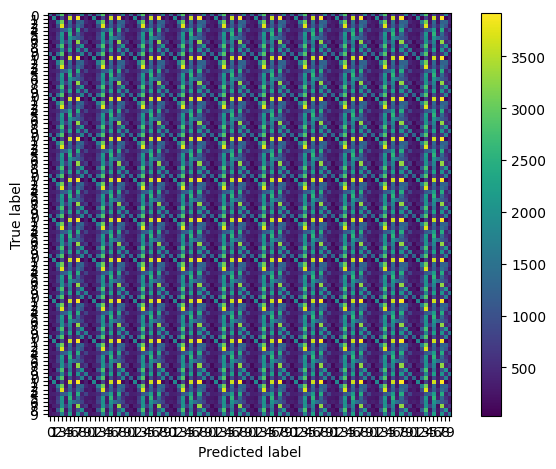

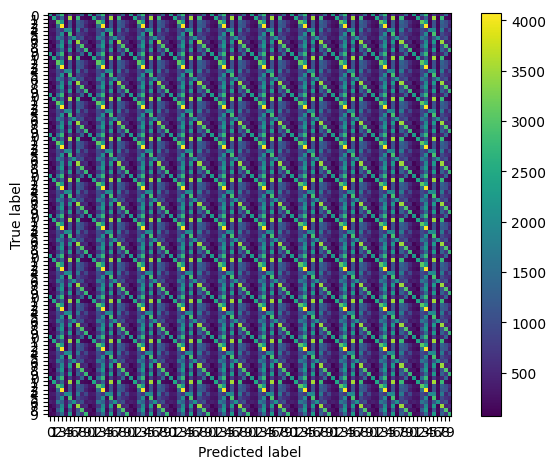

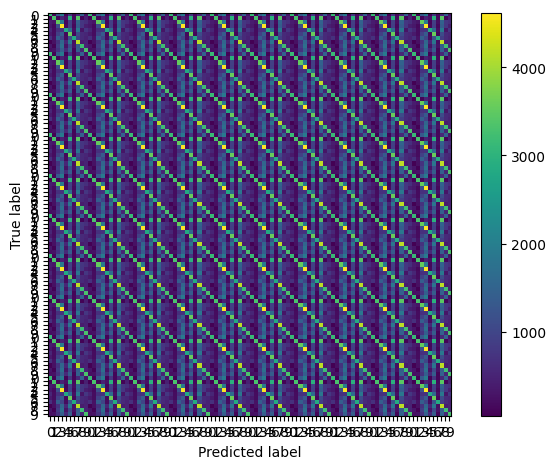

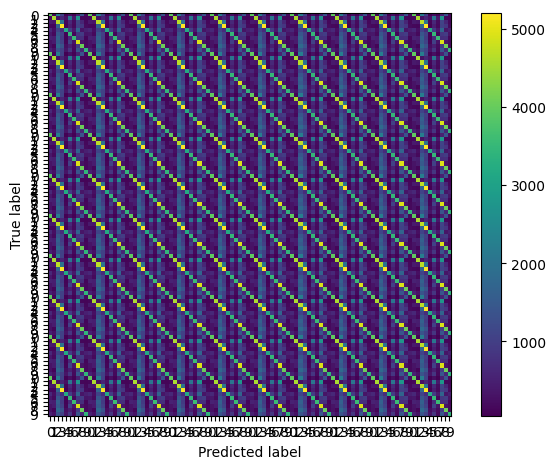

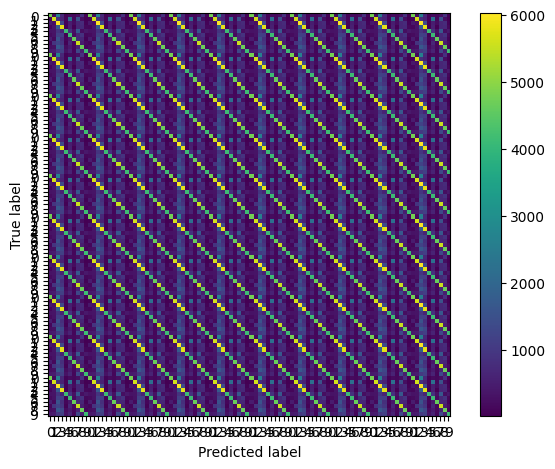

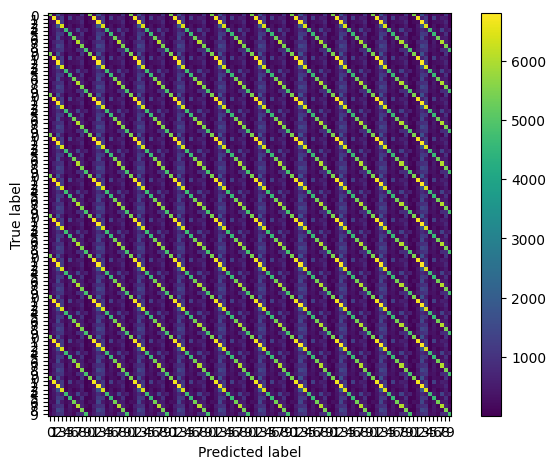

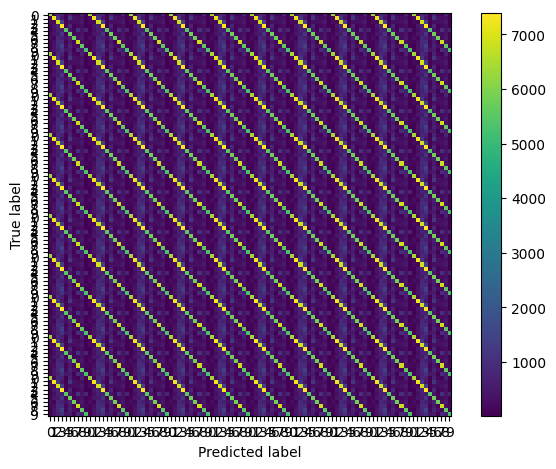

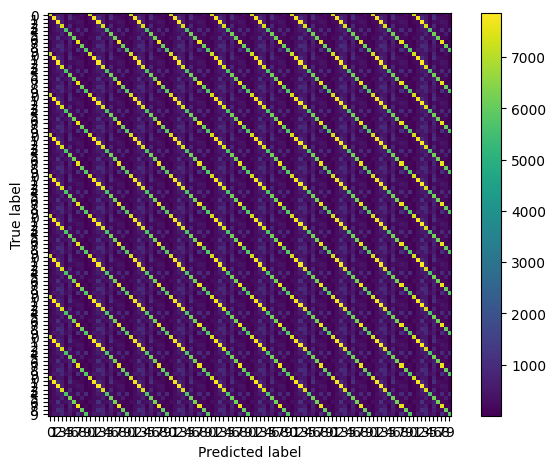

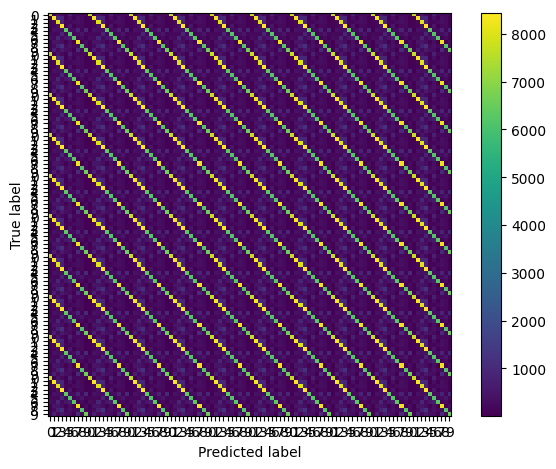

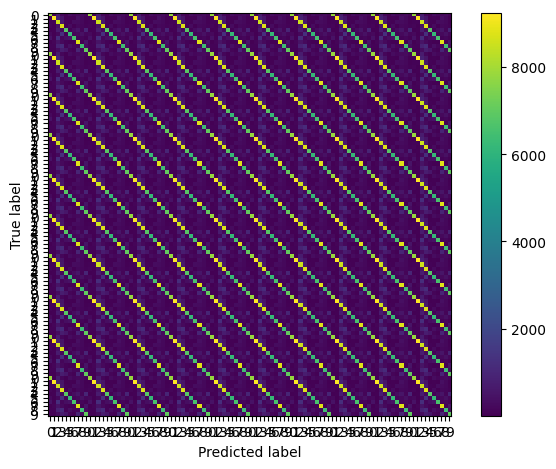

In [14]:
for experience in tqdm(train_stream):
    strategy.train(experience)
    strategy.eval(test_stream)

# Get metrics

In [15]:
accuracies: dict[int, list[float]] = dict()
forgettings: dict[int, list[float]] = dict()
bwt: dict[int, list[float]] = dict()
class_accuracies: dict[int, list[float]] = dict()
losses: dict[int, list[float]] = dict()

for i in range(N_EXPERIENCES):
    filled_i = str(i).zfill(3)
    accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    forgettings[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceForgetting/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    bwt[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceBWT/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    class_accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/{i}"
    ][1]
    losses[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Loss_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
        

accuracies["Overall"] = eval_plugin.get_all_metrics()[
    "Top1_Acc_Stream/eval_phase/test_stream/Task000"
][1]

In [16]:
train_cpu_usage = eval_plugin.get_all_metrics()["CPUUsage_MB/train_phase/train_stream/Task000"][1]
train_time_epoch = eval_plugin.get_all_metrics()["Time_Epoch/train_phase/train_stream/Task000"][1]
train_running_time = eval_plugin.get_all_metrics()["RunningTime_Epoch/train_phase/train_stream/Task000"][1]
train_loss_epoch = eval_plugin.get_all_metrics()["Loss_MB/train_phase/train_stream/Task000"][1]

In [17]:
weights = model_plugins[0].weights

# Store metrics

In [18]:
pickle.dump({
    "accuracies": accuracies,
    "forgettings": forgettings,
    "bwt": bwt,
    "class_accuracies": class_accuracies,
    "losses": losses,
    "train_cpu_usage": train_cpu_usage,
    "train_time_epoch": train_time_epoch,
    "train_running_time": train_running_time,
    "train_loss_epoch": train_loss_epoch,
    "weights": weights
}, open(SAVED_METRICS_PATH / METRICS_FILENAME, "wb"))